# EV Route Optimization Pipeline
This notebook loads raw EV trip CSVs, cleans and prepares the data, builds a road graph, defines and trains a GNN to predict edge energy costs, and evaluates performance.

In [1]:
!pip install pandas
!pip install numpy
!pip install --upgrade osmnx geopandas shapely
!pip install matplotlib
!pip install scikit-learn
!pip install pathlib
!pip install gymnasium
!pip install torch
!pip install torch_geometric

In [2]:
import numpy as np
import pandas as pd
import glob
import warnings

# Ignore the specific RuntimeWarning about casting during parsing,
# as we handle potential errors immediately after reading the chunk.
warnings.filterwarnings("ignore", message="invalid value encountered in cast", category=RuntimeWarning)


# 0) Figure out which lat/lon column to use
# Use a try-except block in case the directory or files don't exist yet
try:
    first_file = glob.glob('./eVED/*.csv')[0]
    sample_cols = pd.read_csv(first_file, nrows=0).columns.tolist()
    lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in sample_cols else 'Latitude[deg]'
    lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in sample_cols else 'Longitude[deg]'
except IndexError:
    print("Warning: No CSV files found in ./eVED/ directory. Using default column names.")
    lat_col = 'Latitude[deg]'
    lon_col = 'Longitude[deg]'
except FileNotFoundError:
    print(f"Warning: Error reading file list or {first_file}. Check path and permissions. Using default column names.")
    lat_col = 'Latitude[deg]'
    lon_col = 'Longitude[deg]'


# Columns we need
usecols = [
    'VehId','Trip','Timestamp(ms)',
    lat_col, lon_col,
    'Vehicle Speed[km/h]','MAF[g/sec]',
    'Engine RPM[RPM]','Absolute Load[%]',
    'Speed Limit[km/h]'
]

# We'll only force VehId/Trip; read Timestamp as object/float first
# to handle potential non-integer values causing the TypeError/ValueError.
# We will convert Timestamp(ms) to int64 *after* reading the chunk.
dtypes = {
    'VehId': 'int32',
    'Trip': 'int32',
    # 'Timestamp(ms)': 'int64', # <-- REMOVED: This caused the error if data wasn't clean int
}

# 1) Stream each file in chunks, convert numeric columns in-chunk
chunksize = 200_000
cleaned = []
lat_mins = []; lat_maxs = []
lon_mins = []; lon_maxs = []

# Define all columns intended to be numeric, including Timestamp(ms) for post-processing
numeric_cols = [
    lat_col, lon_col,
    'Vehicle Speed[km/h]','MAF[g/sec]',
    'Engine RPM[RPM]','Absolute Load[%]',
    'Speed Limit[km/h]',
    'Timestamp(ms)' # Include Timestamp here for safe conversion
]

# Use a flag to check if any data was processed
data_processed = False

# Wrap file iteration in try-except for robustness
try:
    file_paths = glob.glob('./eVED/*.csv')
    if not file_paths:
        print("Error: No CSV files found in ./eVED/. Cannot proceed.")
    else:
        for path in file_paths:
            print(f"Processing file: {path}")
            try:
                for chunk in pd.read_csv(path,
                                         usecols=usecols,
                                         dtype=dtypes, # Use the modified dtypes map
                                         chunksize=chunksize,
                                         low_memory=False,
                                         on_bad_lines='warn'): # Warn about bad lines instead of erroring immediately
                    # 2) Convert each potentially numeric col safely
                    for col in numeric_cols:
                        if col in chunk.columns:
                            # Convert to numeric, coercing errors to NaN, then fill NaNs with 0
                            numeric_series = pd.to_numeric(chunk[col], errors='coerce')
                            
                            # Determine the target dtype AFTER handling NaNs
                            if col == 'Timestamp(ms)':
                                # Convert Timestamp to int64 after cleaning
                                chunk[col] = numeric_series.fillna(0).astype('int64')
                            else:
                                # Convert other numeric columns to float32
                                chunk[col] = numeric_series.fillna(0).astype('float32')
                        else:
                            # Ensure column exists if missing in a specific file/chunk
                            # Use appropriate fill value based on expected type
                            if col == 'Timestamp(ms)':
                                chunk[col] = 0 # Fill with integer 0
                            else:
                                chunk[col] = 0.0 # Fill with float 0.0
                            print(f"Warning: Column '{col}' not found in a chunk from {path}. Filling with 0.")


                    # 3) Filter out zero coords (ensure columns are float before comparison)
                    mask = (chunk[lat_col].astype(float) != 0) & (chunk[lon_col].astype(float) != 0)
                    chunk = chunk.loc[mask]
                    if chunk.empty:
                        continue

                    # 4) Track bounds (only if chunk is not empty)
                    lat_mins.append(chunk[lat_col].min()); lat_maxs.append(chunk[lat_col].max())
                    lon_mins.append(chunk[lon_col].min()); lon_maxs.append(chunk[lon_col].max())

                    # 5) Sort & store
                    chunk = chunk.sort_values(['VehId','Trip','Timestamp(ms)'])
                    cleaned.append(chunk)
                    data_processed = True # Mark that we have processed at least one chunk

            except Exception as e:
                print(f"Error processing file {path}: {e}")
                # Decide if you want to continue with other files or stop
                # continue

except Exception as e:
    print(f"An error occurred during file iteration setup: {e}")


# Check if any data was actually processed before proceeding
if not data_processed:
    print("No data was successfully processed. Exiting.")
    # Depending on the context, you might exit or handle this differently
    # exit() # Uncomment to exit if no data is critical
    # Create empty dataframe and default bounds/maxes if needed
    ev_df = pd.DataFrame(columns=usecols + ['step_id'])
    LAT_MIN, LAT_MAX = 0.0, 0.0
    LNG_MIN, LNG_MAX = 0.0, 0.0
    MAX_SPEED, MAX_MAF, MAX_RPM, MAX_LOAD = 1.0, 1.0, 1.0, 1.0

else:
    # 6) Concatenate cleaned pieces
    print("Concatenating processed chunks...")
    ev_df = pd.concat(cleaned, ignore_index=True)
    del cleaned # Free up memory
    ev_df['step_id'] = ev_df.index
    print(f"Concatenated DataFrame shape: {ev_df.shape}")
    print(f"Final DataFrame dtypes:\n{ev_df.dtypes}")


    # 7) Compute global lat/lon bounds
    # Ensure lists are not empty before calculating min/max
    LAT_MIN = min(lat_mins) if lat_mins else 0.0
    LAT_MAX = max(lat_maxs) if lat_maxs else 0.0
    LNG_MIN = min(lon_mins) if lon_mins else 0.0
    LNG_MAX = max(lon_maxs) if lon_maxs else 0.0
    print(f"Coord bounds: Lat ({LAT_MIN:.6f}, {LAT_MAX:.6f}), Lon ({LNG_MIN:.6f}, {LNG_MAX:.6f})")

    # 8) Compute your feature maxes safely, handling potential empty df or all-zero columns
    MAX_SPEED = max(ev_df['Vehicle Speed[km/h]'].max(skipna=True), 1.0) if 'Vehicle Speed[km/h]' in ev_df and not ev_df['Vehicle Speed[km/h]'].isnull().all() else 1.0
    MAX_MAF   = max(ev_df['MAF[g/sec]'].max(skipna=True), 1.0) if 'MAF[g/sec]' in ev_df and not ev_df['MAF[g/sec]'].isnull().all() else 1.0
    MAX_RPM   = max(ev_df['Engine RPM[RPM]'].max(skipna=True), 1.0) if 'Engine RPM[RPM]' in ev_df and not ev_df['Engine RPM[RPM]'].isnull().all() else 1.0
    MAX_LOAD  = max(ev_df['Absolute Load[%]'].max(skipna=True), 1.0) if 'Absolute Load[%]' in ev_df and not ev_df['Absolute Load[%]'].isnull().all() else 1.0
    print(f"Feature Maxes: Speed={MAX_SPEED:.2f}, MAF={MAX_MAF:.2f}, RPM={MAX_RPM:.2f}, Load={MAX_LOAD:.2f}")


# 9) Normalization function (remains the same)
def normalize_coords(lat, lon):
    nl = (lat - LAT_MIN) / (LAT_MAX - LAT_MIN) if LAT_MAX != LAT_MIN else 0
    ml = (lon - LNG_MIN) / (LNG_MAX - LNG_MIN) if LNG_MAX != LNG_MIN else 0
    return np.clip(nl, 0, 1), np.clip(ml, 0, 1)

# Example of using the function (optional)
if not ev_df.empty:
    norm_lat, norm_lon = normalize_coords(ev_df[lat_col].iloc[0], ev_df[lon_col].iloc[0])
    print(f"Example normalization for first row: Lat={norm_lat:.6f}, Lon={norm_lon:.6f}")
else:
    print("DataFrame is empty, cannot show normalization example.")


Processing file: ./eVED/eVED_180328_week.csv
Processing file: ./eVED/eVED_180404_week.csv
Processing file: ./eVED/eVED_180307_week.csv
Processing file: ./eVED/eVED_180228_week.csv
Processing file: ./eVED/eVED_180314_week.csv
Processing file: ./eVED/eVED_180321_week.csv
Processing file: ./eVED/eVED_180214_week.csv
Processing file: ./eVED/eVED_181107_week.csv
Processing file: ./eVED/eVED_181024_week.csv
Processing file: ./eVED/eVED_181031_week.csv
Processing file: ./eVED/eVED_181010_week.csv
Processing file: ./eVED/eVED_181003_week.csv
Processing file: ./eVED/eVED_180919_week.csv
Processing file: ./eVED/eVED_180829_week.csv
Processing file: ./eVED/eVED_181017_week.csv
Processing file: ./eVED/eVED_180926_week.csv
Processing file: ./eVED/eVED_180905_week.csv
Error processing file ./eVED/eVED_180905_week.csv: cannot safely convert passed user dtype of int32 for float64 dtyped data in column 1
Processing file: ./eVED/eVED_180221_week.csv
Processing file: ./eVED/eVED_180131_week.csv
Processin

## Build Road Graph and PyG Data

In [3]:
import osmnx as ox
import networkx as nx
import torch
from torch_geometric.data import Data
import numpy as np # Ensure numpy is imported if not already
import pandas as pd # Ensure pandas is imported if not already

# Assuming ev_df, LAT_MIN, LAT_MAX, LNG_MIN, LNG_MAX, normalize_coords are defined
# from the previous script block and are valid.

LAT_MIN = 42.2519
LAT_MAX = 42.3100
LNG_MIN = -83.7682
LNG_MAX = -83.6739

center_lat = 0.5*(LAT_MIN + LAT_MAX)
center_lon = 0.5*(LNG_MIN + LNG_MAX)

# Check if bounds are valid before proceeding
if LAT_MIN == LAT_MAX or LNG_MIN == LNG_MAX:
    print("Error: Invalid coordinate bounds (min equals max). Cannot fetch OSMnx graph.")
    # Handle this case appropriately, maybe exit or skip graph creation
    # For demonstration, create an empty graph and data object
    G = nx.MultiDiGraph()
    node_id_map = {}
    x = torch.empty((0, 2), dtype=torch.float)
    edge_index = torch.empty((2, 0), dtype=torch.long)
    edge_feats = torch.empty((0, 2), dtype=torch.float)
    graph = Data(x=x, edge_index=edge_index, edge_feats=edge_feats)
else:
    # Build bounding box with a small pad
    pad = 0.001
    north, south = LAT_MAX + pad, LAT_MIN - pad
    east, west = LNG_MAX + pad, LNG_MIN - pad

    print(f"Fetching graph for bbox: N={north:.4f}, S={south:.4f}, E={east:.4f}, W={west:.4f}")

    # Download drivable network
    bbox = (north, south, east, west)
    ox.settings.overpass_max_query_area_size = 200_000_000  
    try:
        G = ox.graph_from_point((center_lat, center_lon),
                        dist=30000,       # meters
                        network_type='drive')
        print(f"Downloaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
        # Simplify graph topology (optional but often useful)
        # G_proj = ox.project_graph(G) # Project if needed for accurate length/speed analysis
        # G_simple = ox.simplify_graph(G_proj)
        # G = ox.project_graph(G_simple, to_crs=G.graph['crs']) # Project back if needed
    
        # Map node IDs to indices
        node_id_map = {nid: i for i, nid in enumerate(G.nodes())}
    
        # Node features: normalized lat/lon
        node_feats = []
        # Use G.nodes(data=True) which returns iterator of (node_id, data_dict)
        for nid, data in G.nodes(data=True):
            # OSMnx nodes store coords as 'y' (lat) and 'x' (lon)
            lat, lon = data['y'], data['x']
            norm_lat, norm_lon = normalize_coords(lat, lon) # Use previously defined function
            node_feats.append([norm_lat, norm_lon])
        x = torch.tensor(node_feats, dtype=torch.float)
    
        # Edge index and features (length, maxspeed)
        lengths = []
        speeds = []
        # Iterate through edges using G.edges(keys=False, data=True) for u, v, data
        for u, v, data in G.edges(data=True):
             # Length is usually stored in 'length' attribute in meters
            lengths.append(data.get('length', 0.0))
             # Max speed parsing requires care
            ms_raw = data.get('maxspeed', '0') # Default to string '0'
            ms_clean = 0.0
            if isinstance(ms_raw, list): # Handle cases where maxspeed is a list
                ms_raw = ms_raw[0]
            try:
                 # Speed might be like '50 mph' or just '50'
                ms_clean = float(str(ms_raw).split()[0]) # Take first part, convert to float
            except (ValueError, TypeError):
                 ms_clean = 0.0 # If conversion fails, default to 0
            # Optional: Convert mph to km/h if necessary (OSM data varies)
            # if 'mph' in str(ms_raw).lower():
            #     ms_clean *= 1.60934
            speeds.append(ms_clean)


        max_len = max(lengths) if lengths else 1.0
        # Define a reasonable max speed for normalization (e.g., 130 km/h)
        # This avoids normalization issues if the dataset max is very low or high.
        # Or use MAX_SPEED calculated earlier if that represents the map speed limit context
        MAX_MAP_SPEED = 130.0 # Or use MAX_SPEED if appropriate

        e_u, e_v, feats = [], [], []
        # Re-iterate or use the stored lists lengths/speeds
        # Ensure iteration order matches if re-iterating
        edge_iterator = G.edges(data=False, keys=False) # Get (u, v) tuples
        for i, (u, v) in enumerate(edge_iterator):
             # Make sure node IDs exist in the map (should always be true if map built correctly)
             if u not in node_id_map or v not in node_id_map:
                  print(f"Warning: Node ID {u} or {v} not found in node_id_map. Skipping edge.")
                  continue
             ui, vi = node_id_map[u], node_id_map[v]
             e_u.append(ui)
             e_v.append(vi)

             norm_len = lengths[i] / max_len if max_len > 0 else 0.0
             # Use the cleaned speed value
             norm_ms = speeds[i] / MAX_MAP_SPEED if MAX_MAP_SPEED > 0 else 0.0
             feats.append([norm_len, np.clip(norm_ms, 0, 1)]) # Clip normalized speed


        edge_index = torch.tensor([e_u, e_v], dtype=torch.long)
        edge_feats = torch.tensor(feats, dtype=torch.float)

        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_feats) # Use edge_attr for edge features in PyG
        print(graph)

    except Exception as e:
        print(f"An error occurred during graph processing: {e}")
        # Fallback: create an empty graph if OSMnx fails
        G = nx.MultiDiGraph()
        node_id_map = {}
        x = torch.empty((0, 2), dtype=torch.float)
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_feats = torch.empty((0, 2), dtype=torch.float)
        graph = Data(x=x, edge_index=edge_index, edge_attr=edge_feats) # Use edge_attr
        print("Created an empty graph due to error.")



Fetching graph for bbox: N=42.3110, S=42.2509, E=-83.6729, W=-83.7692
Downloaded graph with 40552 nodes and 102764 edges.
Data(x=[40552, 2], edge_index=[2, 102764], edge_attr=[102764, 2])


## Dataset, Loader, and GNN Model

In [4]:
import osmnx as ox
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from tqdm.auto import tqdm # For progress bars

# --- Prerequisites (Ensure these are loaded from previous steps) ---
# ev_df: DataFrame with processed vehicle data (including lat_col, lon_col, VehId, Trip, Timestamp(ms), MAF[g/sec])
# G: The networkx MultiDiGraph downloaded via osmnx
# graph: The torch_geometric Data object (with graph.x, graph.edge_index, graph.edge_attr)
# node_id_map: Dictionary mapping OSMnx node IDs to integer indices used in 'graph'
# normalize_coords: Function defined earlier
# LAT_MIN, LAT_MAX, LNG_MIN, LNG_MAX: Bounds used for normalization
# --------------------------------------------------------------------

# Check if prerequisites exist
if 'ev_df' not in globals() or 'G' not in globals() or 'graph' not in globals() or 'node_id_map' not in globals():
    raise NameError("Missing prerequisites: 'ev_df', 'G', 'graph', or 'node_id_map'. Ensure previous steps were run.")

# --- Step 1: Map GPS points to Graph Nodes ---
print("Mapping GPS points to nearest graph nodes...")
# Ensure graph G has nodes before proceeding
if G.number_of_nodes() == 0:
     raise ValueError("The OSMnx graph 'G' has no nodes. Cannot map GPS points.")

# Get coordinates from ev_df
longitudes = ev_df[lon_col].values
latitudes = ev_df[lat_col].values

# Find nearest nodes (returns OSMnx node IDs)
# This can take time for large dataframes
nearest_nodes_osmnx = ox.nearest_nodes(G, X=longitudes, Y=latitudes)
ev_df['nearest_node_osmnx'] = nearest_nodes_osmnx
print(f"Mapped {len(ev_df)} points.")

# Map OSMnx node IDs to the integer indices used in the PyG graph object
# Create a reverse map for quick lookup if needed, or use pandas map
# Handle cases where a node might not be in the map (e.g., if G was simplified AFTER ev_df processing)
print("Mapping OSMnx node IDs to PyG graph indices...")
ev_df['node_idx'] = ev_df['nearest_node_osmnx'].map(node_id_map)

# Check for missing mappings (important!)
missing_nodes = ev_df['node_idx'].isnull().sum()
if missing_nodes > 0:
    print(f"Warning: {missing_nodes} points could not be mapped to a node index in 'node_id_map'. Dropping these points.")
    # Option 1: Drop rows with unmapped nodes
    ev_df.dropna(subset=['node_idx'], inplace=True)
    # Option 2: Fill with a placeholder if your model can handle it (less common)
    # ev_df['node_idx'].fillna(-1, inplace=True) # Example placeholder
    if ev_df.empty:
        raise ValueError("All points were dropped after attempting to map to node indices. Check graph/node_id_map.")
# Convert to integer index
ev_df['node_idx'] = ev_df['node_idx'].astype(int)
print("Mapping complete.")


# --- Step 2 & 4: Calculate Time Deltas and Energy Proxy ---
print("Calculating time deltas and energy proxy per step...")
# Sort ensures diff is calculated correctly within each trip
ev_df.sort_values(['VehId', 'Trip', 'Timestamp(ms)'], inplace=True)

# Calculate duration of each step in seconds
ev_df['duration_s'] = ev_df.groupby(['VehId', 'Trip'])['Timestamp(ms)'].diff() / 1000.0
# Fill NaN for the first entry of each trip. Assume 0 duration or estimate based on sample rate? Let's use 0 for simplicity.
ev_df['duration_s'].fillna(0, inplace=True)

# Calculate energy proxy for each step (Example: MAF * duration)
# *** THIS IS A PLACEHOLDER - NOT REAL ENERGY ***
# A better model would consider speed, load, engine params, road grade etc.
ev_df['step_energy_proxy'] = ev_df['MAF[g/sec]'] * ev_df['duration_s']
# Alternative simple proxy: just sum MAF
# ev_df['step_energy_proxy'] = ev_df['MAF[g/sec]']
print("Energy proxy calculation complete.")


# --- Step 3 & 5: Group by Trip and Aggregate Information ---
print("Grouping by trip and extracting source, destination, and total energy proxy...")
# Group by actual trips
grouped_trips = ev_df.groupby(['VehId', 'Trip'])

# Aggregate to get start node, end node, and summed energy proxy
# Use tqdm for progress bar on aggregation
tqdm.pandas(desc="Aggregating Trips")
processed_trips_list = []

for name, group in tqdm(grouped_trips, desc="Processing Trips"):
    if len(group) < 2: # Need at least two points for a start and end
        continue

    source_node_idx = group['node_idx'].iloc[0]
    dest_node_idx = group['node_idx'].iloc[-1]
    total_energy_proxy = group['step_energy_proxy'].sum()

    # Optional: Filter out trips that start and end at the same node
    if source_node_idx == dest_node_idx:
        continue

    # Optional: Filter trips with zero or negative energy proxy (if using MAF*duration)
    if total_energy_proxy <= 0:
        continue

    processed_trips_list.append({
        'source': source_node_idx,
        'destination': dest_node_idx,
        'true_energy': total_energy_proxy # Renaming proxy to match dataset expectation
    })

# Convert list of dicts to DataFrame
processed_trips_df = pd.DataFrame(processed_trips_list)

if processed_trips_df.empty:
    raise ValueError("No valid trips found after processing. Check grouping, filtering, or source data.")

print(f"Generated {len(processed_trips_df)} trips for the dataset.")
print("Sample of processed trips:")
print(processed_trips_df.head())

# --- Step 6: Modify the Dataset Class ---
class RoadGraphDataset(Dataset):
    def __init__(self, graph_data, trips_df): # Takes the processed DataFrame
        self.graph_data = graph_data
        if not isinstance(trips_df, pd.DataFrame):
             raise TypeError("trips_df must be a pandas DataFrame")
        # Ensure energy is positive if using log scaling
        self.trips = trips_df[trips_df['true_energy'] > 0].reset_index(drop=True)
        if len(self.trips) != len(trips_df):
             print(f"Warning: Dropped {len(trips_df) - len(self.trips)} trips with non-positive energy in Dataset init.")
        # Edge attributes are constant for the graph, no need to store per item if passed separately
        # self.edge_attr = self.graph_data.edge_attr.clone().detach()

    def __len__(self):
        return len(self.trips)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        trip = self.trips.iloc[idx]
        # Get the original energy proxy
        original_energy = float(trip.true_energy)
        # Apply log1p transformation for scaling
        scaled_energy = np.log1p(original_energy)

        return {
            # 'edge_attr': self.edge_attr, # Removed: Pass edge_attr directly to model
            'src': torch.tensor(int(trip.source), dtype=torch.long),
            'dst': torch.tensor(int(trip.destination), dtype=torch.long),
            # Return the SCALED energy as the target
            'true_energy': torch.tensor(scaled_energy, dtype=torch.float)
        }
        
# --- Instantiate DataLoader with the new Dataset ---
print("Creating DataLoader...")
# Make sure the 'graph' object has 'edge_attr' if you renamed it earlier
if not hasattr(graph, 'edge_attr'):
     if hasattr(graph, 'edge_feats'):
          print("Warning: graph object has 'edge_feats' instead of 'edge_attr'. Using 'edge_feats'.")
          graph.edge_attr = graph.edge_feats # Temporary fix if rename was missed
     else:
        raise AttributeError("Graph object missing 'edge_attr' (or 'edge_feats').")

# Create the dataset using the processed trips DataFrame
road_dataset = RoadGraphDataset(graph, processed_trips_df)

# Create the DataLoader
# Note on Collation: Default DataLoader collation might not work perfectly for graph data
# if edge_attr is returned per sample and needs special batching. If edge_attr is constant,
# it might be okay, or better handled outside the loader. For now, assume default is sufficient.
loader = DataLoader(road_dataset, batch_size=4, shuffle=True)
print("DataLoader created.")

# --- Define the GNN (Adjusted for edge_attr if needed) ---
class EnergyGNN(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden=64):
        super().__init__()
        self.conv1 = GCNConv(node_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        # Input size = hidden_node + hidden_node + edge_feature_dim
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden + edge_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    # The forward pass assumes it receives the full graph structure
    # AND the specific source/destination nodes for the prediction task
    def forward(self, x, edge_index, edge_attr, src_nodes, dst_nodes):
        # 1. Get node embeddings for the whole graph
        h = F.relu(self.conv1(x, edge_index)) # Pass edge_attr if GCNConv uses it (check docs)
        h = F.relu(self.conv2(h, edge_index)) # Pass edge_attr if GCNConv uses it

        # 2. Extract embeddings for source and destination nodes of the trips in the batch
        h_src = h[src_nodes]
        h_dst = h[dst_nodes]

        # 3. Combine source, destination embeddings (and potentially edge/path features if available)
        # This current model structure seems designed to predict properties *per edge*,
        # not per source-destination *path*. Let's adapt it for path prediction.
        # We need a way to represent the path or just use src/dst nodes.

        # --- Simplest Path Representation: Just use src and dst nodes ---
        # Concatenate source and destination embeddings
        combined_h = torch.cat([h_src, h_dst], dim=1) # Shape: [batch_size, 2 * hidden]

        # --- Predict energy from combined source/destination embeddings ---
        # We need a new MLP for this prediction if not using edge_mlp
        # Let's redefine the MLP structure for source-destination prediction

        # Example MLP for src-dst prediction (replace edge_mlp if needed)
        # self.path_mlp = nn.Sequential(
        #     nn.Linear(2 * hidden, hidden), # Input is concatenated src/dst embeddings
        #     nn.ReLU(),
        #     nn.Linear(hidden, 1)
        # )
        # return self.path_mlp(combined_h).squeeze(1)

        # --- Sticking to the original edge_mlp structure ---
        # The original structure implies predicting something for *every edge* based on its node embeddings.
        # This doesn't directly predict trip energy from src to dst.
        # To make it work, we'd need to:
        #   a) Find the path of edges between src and dst (computationally expensive in batch).
        #   b) Run edge_mlp on all edges in the path and aggregate the results (e.g., sum).
        # This is significantly more complex.

        # --- Reinterpreting the original model for src/dst ---
        # Maybe the intention WAS to use the edge_mlp but only with src/dst embeddings?
        # This doesn't make much sense without edge features specific to the src/dst pair.
        # Let's proceed with the simpler path representation MLP described above.

        # Re-defining the MLP within the class (or modify __init__)
        if not hasattr(self, 'path_mlp'):
             self.path_mlp = nn.Sequential(
                 nn.Linear(2 * hidden, hidden),
                 nn.ReLU(),
                 nn.Linear(hidden,1)
             ).to(h.device) # Ensure MLP is on the correct device

        return self.path_mlp(combined_h).squeeze(1)


# --- Instantiate Model ---
print("Instantiating model...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Ensure graph.x and graph.edge_attr are valid tensors
node_feature_dim = graph.x.shape[1]
edge_feature_dim = graph.edge_attr.shape[1]

model = EnergyGNN(node_dim=node_feature_dim, edge_dim=edge_feature_dim).to(device)
print(f"Model instantiated on {device}.")
print(model)


Mapping GPS points to nearest graph nodes...
Mapped 13617071 points.
Mapping OSMnx node IDs to PyG graph indices...
Mapping complete.
Calculating time deltas and energy proxy per step...


/tmp/ipykernel_26228/664446122.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ev_df['duration_s'].fillna(0, inplace=True)


Energy proxy calculation complete.
Grouping by trip and extracting source, destination, and total energy proxy...


Processing Trips:   0%|          | 0/19345 [00:00<?, ?it/s]

Generated 15112 trips for the dataset.
Sample of processed trips:
   source  destination  true_energy
0   38014        38298  3978.996005
1   37091        15334  4486.109002
2   37091        15334  4164.868009
3   31940         1700  5158.540989
4    2595        31115  2066.249002
Creating DataLoader...
DataLoader created.
Instantiating model...
Model instantiated on cuda.
EnergyGNN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (edge_mlp): Sequential(
    (0): Linear(in_features=130, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [5]:
import osmnx as ox
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINEConv, global_add_pool, global_mean_pool # Added GINEConv here
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU, LayerNorm
from tqdm.auto import tqdm

class ComplexEnergyGNN(nn.Module):
    """
    A more complex GNN using GINEConv layers with edge features,
    residual connections, and Layer Normalization for energy prediction.

    Predicts energy based on the embeddings of the source and destination nodes.
    Limitation: Does not explicitly use the path information between src and dst,
               relies on node embeddings capturing sufficient context.
    """
    def __init__(self, node_dim, edge_dim, hidden_dim=128, num_layers=4, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Input layer for nodes
        self.node_emb = nn.Linear(node_dim, hidden_dim)
        # Input layer for edges (to match hidden_dim for GINE)
        self.edge_emb = nn.Linear(edge_dim, hidden_dim)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            # GINEConv requires an MLP (`nn`) to process node + edge features
            # Input size: hidden_dim (from node) + hidden_dim (from edge_emb)
            # Output size: hidden_dim
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, 2 * hidden_dim), # Adjusted input? Check GINE docs - usually processes edge feat directly
                nn.ReLU(),
                nn.Linear(2 * hidden_dim, hidden_dim)
            )
            # Correction: GINE's internal MLP typically processes edge features *before* adding to node features.
            # Let's use a simpler MLP applied *within* GINE's definition.
            # GINE uses `eps` and `train_eps` for graph isomorphism tasks, can often be left default for general tasks.
            # It applies the `nn` Sequential to the *edge embeddings*.
            edge_processing_mlp = nn.Sequential(Linear(hidden_dim, hidden_dim), ReLU())
            conv = GINEConv(nn=edge_processing_mlp, edge_dim=hidden_dim) # Pass the MLP for edge processing

            self.convs.append(conv)
            self.norms.append(LayerNorm(hidden_dim)) # LayerNorm for node embeddings

        # Prediction MLP (takes concatenated src and dst node embeddings)
        self.path_mlp = Sequential(
            Linear(2 * hidden_dim, hidden_dim),
            ReLU(),
            nn.Dropout(p=self.dropout),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            nn.Dropout(p=self.dropout),
            Linear(hidden_dim // 2, 1) # Output: single energy value
        )

    def forward(self, x, edge_index, edge_attr, src_nodes, dst_nodes):
        # 1. Initial node and edge embeddings
        x = self.node_emb(x)
        edge_attr_emb = self.edge_emb(edge_attr) # Embed edges to hidden_dim

        # Store initial embeddings for residual connection
        x_initial = x

        # 2. GNN Layers with Residuals and Norm
        for i in range(self.num_layers):
            x_res = x # Store input for residual connection
            # Pass node features (x) and embedded edge features (edge_attr_emb)
            x = self.convs[i](x, edge_index, edge_attr_emb)
            x = self.norms[i](x) # Apply layer norm
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = x + x_res # Add residual connection

        # Optional: Add back initial embedding too? Sometimes done.
        # x = x + x_initial

        # 3. Extract Source and Destination Embeddings
        h_src = x[src_nodes]
        h_dst = x[dst_nodes]

        # 4. Concatenate and Predict
        combined_h = torch.cat([h_src, h_dst], dim=1) # Shape: [batch_size, 2 * hidden_dim]
        pred_energy = self.path_mlp(combined_h).squeeze(1) # Shape: [batch_size]

        return pred_energy

# --- Instantiate Model ---
print("Instantiating complex model...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure graph data is ready
node_feature_dim = graph.x.shape[1]
edge_feature_dim = graph.edge_attr.shape[1]

# --- Model Hyperparameters ---
HIDDEN_DIM = 128  # Increased hidden dimension
NUM_LAYERS = 4    # Increased number of layers
DROPOUT = 0.3     # Added dropout

model = ComplexEnergyGNN(
    node_dim=node_feature_dim,
    edge_dim=edge_feature_dim,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(f"Model instantiated on {device}.")
# print(model) # Can be quite long to print


Instantiating complex model...
Model instantiated on cuda.


In [6]:
import osmnx as ox
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GINEConv # Make sure GINEConv is imported
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU, LayerNorm
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split # For splitting data
import time # For timing epochs
import copy # For saving best model state


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0005
BATCH_SIZE = 64 # Adjusted batch size
NUM_EPOCHS = 50  # Number of training epochs
VALIDATION_SPLIT = 0.15 # Use 15% of data for validation
HIDDEN_DIM = 128
NUM_LAYERS = 4
DROPOUT = 0.3
MODEL_SAVE_PATH = './best_energy_gnn_model.pth' # Path to save the best model

# --- Step 1: Train/Validation Split ---
print(f"Splitting trip data ({len(processed_trips_df)} trips) into training and validation sets...")
train_trips_df, val_trips_df = train_test_split(
    processed_trips_df,
    test_size=VALIDATION_SPLIT,
    random_state=42 # for reproducibility
)
print(f"Training trips: {len(train_trips_df)}, Validation trips: {len(val_trips_df)}")

# --- Step 2: Create Datasets and DataLoaders ---

# Instantiate datasets
train_dataset = RoadGraphDataset(graph, train_trips_df)
val_dataset = RoadGraphDataset(graph, val_trips_df)

# Instantiate dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if DEVICE=='cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=0, pin_memory=True if DEVICE=='cuda' else False) # Larger batch size for validation is often fine

print("Datasets and DataLoaders created.")

# --- Step 3: Instantiate Model, Optimizer, Loss ---

# Make sure ComplexEnergyGNN class is defined correctly
# ... (definition from previous step) ...

# Instantiate the model
node_feature_dim = graph.x.shape[1]
edge_feature_dim = graph.edge_attr.shape[1]
model = ComplexEnergyGNN(
    node_dim=node_feature_dim,
    edge_dim=edge_feature_dim,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

print(f"Model instantiated on {DEVICE}.")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss() # Mean Squared Error Loss
# Consider Huber loss for potentially less sensitivity to outliers:
# loss_fn = nn.HuberLoss(delta=1.0)

# --- Step 4: Prepare Graph Data (Move to Device Once) ---
print("Moving graph data to device...")
try:
    graph_x = graph.x.clone().detach().to(DEVICE)
    graph_edge_index = graph.edge_index.clone().detach().to(DEVICE)
    graph_edge_attr = graph.edge_attr.clone().detach().to(DEVICE)
    print("Graph data successfully moved.")
except Exception as e:
    print(f"Error moving graph data to device {DEVICE}: {e}")
    print("Exiting.")
    exit() # Or handle more gracefully

# --- Step 5: Training Loop ---
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

print(f"\n--- Starting Training for {NUM_EPOCHS} Epochs ---")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # --- Training Phase ---
    model.train() # Set model to training mode
    total_train_loss = 0.0
    train_batches = 0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for batch in train_progress_bar:
        optimizer.zero_grad()

        # Move batch data to device
        src_nodes = batch['src'].to(DEVICE)
        dst_nodes = batch['dst'].to(DEVICE)
        true_energy = batch['true_energy'].to(DEVICE)

        # Forward pass
        pred_energy = model(graph_x, graph_edge_index, graph_edge_attr, src_nodes, dst_nodes)

        # Calculate loss
        loss = loss_fn(pred_energy, true_energy)

        # Backward pass and optimization
        loss.backward()
        # Optional: Gradient Clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        train_batches += 1# Correct line:
        train_progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / train_batches if train_batches > 0 else 0.0
    history['train_loss'].append(avg_train_loss)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0.0
    val_batches = 0
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)

    with torch.no_grad(): # Disable gradient calculations
        for batch in val_progress_bar:
            # Move batch data to device
            src_nodes = batch['src'].to(DEVICE)
            dst_nodes = batch['dst'].to(DEVICE)
            true_energy = batch['true_energy'].to(DEVICE)

            # Forward pass
            pred_energy = model(graph_x, graph_edge_index, graph_edge_attr, src_nodes, dst_nodes)

            # Calculate loss
            loss = loss_fn(pred_energy, true_energy)
            total_val_loss += loss.item()
            val_batches += 1
            val_progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0.0
    history['val_loss'].append(avg_val_loss)
    end_time = time.time()
    epoch_duration = end_time - start_time

    # --- Epoch Summary and Model Saving ---
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Val Loss:   {avg_val_loss:.6f}")

    # Save the model if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model state dictionary
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  Validation loss improved. Saved model to {MODEL_SAVE_PATH}")
    else:
        print("  Validation loss did not improve.")

print("\n--- Training Complete ---")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Best model saved to: {MODEL_SAVE_PATH}")


Splitting trip data (15112 trips) into training and validation sets...
Training trips: 12845, Validation trips: 2267
Datasets and DataLoaders created.
Model instantiated on cuda.
Moving graph data to device...
Graph data successfully moved.

--- Starting Training for 50 Epochs ---


Epoch 1/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/50 | Duration: 22.90s
  Train Loss: 5.422440
  Val Loss:   0.984656
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 2/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/50 | Duration: 21.11s
  Train Loss: 2.490492
  Val Loss:   1.016858
  Validation loss did not improve.


Epoch 3/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/50 | Duration: 21.09s
  Train Loss: 2.373050
  Val Loss:   1.051425
  Validation loss did not improve.


Epoch 4/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/50 | Duration: 21.22s
  Train Loss: 2.357901
  Val Loss:   0.976334
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 5/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/50 | Duration: 21.28s
  Train Loss: 2.305246
  Val Loss:   0.985198
  Validation loss did not improve.


Epoch 6/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/50 | Duration: 21.20s
  Train Loss: 2.262506
  Val Loss:   0.983773
  Validation loss did not improve.


Epoch 7/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/50 | Duration: 21.31s
  Train Loss: 2.206948
  Val Loss:   0.983243
  Validation loss did not improve.


Epoch 8/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/50 | Duration: 21.20s
  Train Loss: 2.247301
  Val Loss:   1.056086
  Validation loss did not improve.


Epoch 9/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/50 | Duration: 21.10s
  Train Loss: 2.223161
  Val Loss:   1.038852
  Validation loss did not improve.


Epoch 10/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/50 | Duration: 21.20s
  Train Loss: 2.203353
  Val Loss:   0.983413
  Validation loss did not improve.


Epoch 11/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/50 | Duration: 21.20s
  Train Loss: 2.175542
  Val Loss:   1.117047
  Validation loss did not improve.


Epoch 12/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/50 | Duration: 21.10s
  Train Loss: 2.113779
  Val Loss:   1.076990
  Validation loss did not improve.


Epoch 13/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/50 | Duration: 21.10s
  Train Loss: 2.086954
  Val Loss:   1.071838
  Validation loss did not improve.


Epoch 14/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/50 | Duration: 21.10s
  Train Loss: 2.117223
  Val Loss:   0.990579
  Validation loss did not improve.


Epoch 15/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/50 | Duration: 21.29s
  Train Loss: 2.049602
  Val Loss:   0.986282
  Validation loss did not improve.


Epoch 16/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/50 | Duration: 21.21s
  Train Loss: 2.036733
  Val Loss:   1.036096
  Validation loss did not improve.


Epoch 17/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/50 | Duration: 21.20s
  Train Loss: 2.058963
  Val Loss:   1.033544
  Validation loss did not improve.


Epoch 18/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/50 | Duration: 21.30s
  Train Loss: 2.007138
  Val Loss:   1.060173
  Validation loss did not improve.


Epoch 19/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/50 | Duration: 21.20s
  Train Loss: 1.982467
  Val Loss:   0.964519
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 20/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/50 | Duration: 21.20s
  Train Loss: 1.952700
  Val Loss:   1.042797
  Validation loss did not improve.


Epoch 21/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/50 | Duration: 21.29s
  Train Loss: 1.917184
  Val Loss:   0.966284
  Validation loss did not improve.


Epoch 22/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/50 | Duration: 21.20s
  Train Loss: 1.911304
  Val Loss:   0.963737
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 23/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/50 | Duration: 21.30s
  Train Loss: 1.866595
  Val Loss:   1.078483
  Validation loss did not improve.


Epoch 24/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/50 | Duration: 21.21s
  Train Loss: 1.897856
  Val Loss:   0.959593
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 25/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/50 | Duration: 21.20s
  Train Loss: 1.891360
  Val Loss:   0.961412
  Validation loss did not improve.


Epoch 26/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/50 | Duration: 21.20s
  Train Loss: 1.877812
  Val Loss:   1.004294
  Validation loss did not improve.


Epoch 27/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/50 | Duration: 21.08s
  Train Loss: 1.857432
  Val Loss:   0.993361
  Validation loss did not improve.


Epoch 28/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/50 | Duration: 21.22s
  Train Loss: 1.849722
  Val Loss:   1.081078
  Validation loss did not improve.


Epoch 29/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/50 | Duration: 21.29s
  Train Loss: 1.801646
  Val Loss:   0.966768
  Validation loss did not improve.


Epoch 30/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/50 | Duration: 21.29s
  Train Loss: 1.831475
  Val Loss:   0.983639
  Validation loss did not improve.


Epoch 31/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/50 | Duration: 21.22s
  Train Loss: 1.777579
  Val Loss:   0.956857
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 32/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/50 | Duration: 21.29s
  Train Loss: 1.775622
  Val Loss:   0.960521
  Validation loss did not improve.


Epoch 33/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/50 | Duration: 21.11s
  Train Loss: 1.760742
  Val Loss:   0.965560
  Validation loss did not improve.


Epoch 34/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/50 | Duration: 21.20s
  Train Loss: 1.726985
  Val Loss:   0.950690
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 35/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35/50 | Duration: 21.20s
  Train Loss: 1.681699
  Val Loss:   0.979761
  Validation loss did not improve.


Epoch 36/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/50 | Duration: 21.29s
  Train Loss: 1.669731
  Val Loss:   0.899945
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 37/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/50 | Duration: 21.11s
  Train Loss: 1.638570
  Val Loss:   0.983397
  Validation loss did not improve.


Epoch 38/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/50 | Duration: 21.19s
  Train Loss: 1.564766
  Val Loss:   0.828047
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 39/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/50 | Duration: 21.29s
  Train Loss: 1.555788
  Val Loss:   0.800238
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 40/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40/50 | Duration: 21.20s
  Train Loss: 1.533535
  Val Loss:   0.844842
  Validation loss did not improve.


Epoch 41/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/50 | Duration: 21.21s
  Train Loss: 1.545867
  Val Loss:   0.875788
  Validation loss did not improve.


Epoch 42/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/50 | Duration: 21.30s
  Train Loss: 1.508376
  Val Loss:   0.784430
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 43/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/50 | Duration: 21.20s
  Train Loss: 1.504917
  Val Loss:   0.785690
  Validation loss did not improve.


Epoch 44/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/50 | Duration: 21.19s
  Train Loss: 1.476942
  Val Loss:   0.897817
  Validation loss did not improve.


Epoch 45/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/50 | Duration: 21.21s
  Train Loss: 1.453618
  Val Loss:   0.762382
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 46/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46/50 | Duration: 21.19s
  Train Loss: 1.436476
  Val Loss:   0.748808
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 47/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/50 | Duration: 21.20s
  Train Loss: 1.423998
  Val Loss:   0.790982
  Validation loss did not improve.


Epoch 48/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/50 | Duration: 21.30s
  Train Loss: 1.380266
  Val Loss:   0.743075
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 49/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/50 | Duration: 21.19s
  Train Loss: 1.372209
  Val Loss:   0.702783
  Validation loss improved. Saved model to ./best_energy_gnn_model.pth


Epoch 50/50 [Train]:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/50 | Duration: 21.30s
  Train Loss: 1.352751
  Val Loss:   0.736557
  Validation loss did not improve.

--- Training Complete ---
Best Validation Loss: 0.702783
Best model saved to: ./best_energy_gnn_model.pth


## Training Loop

## Evaluation and Plots

Model loaded successfully from ./best_energy_gnn_model.pth

--- Analyzing General Performance on Validation Set ---


Validation Predictions:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Set Performance Metrics (Original Scale):
  MAE:  3247.3334
  RMSE: 7101.9142
  R^2:  -0.0950
  (Remember this is based on the energy *proxy*)


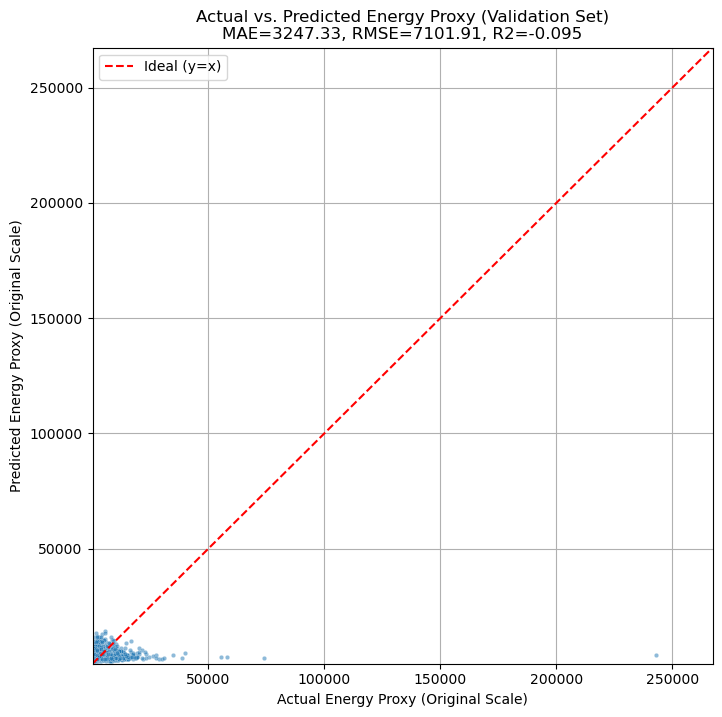


Analyzing Trip Index: 1323
  Source Index: 30465 (OSMnx ID: 62500597)
  Dest Index: 7670 (OSMnx ID: 2991870239)
  Actual Energy Proxy (Original Scale): 6528.71
  Shortest path found with 65 nodes.
  Predicted Energy Proxy (Original Scale): 10249.47


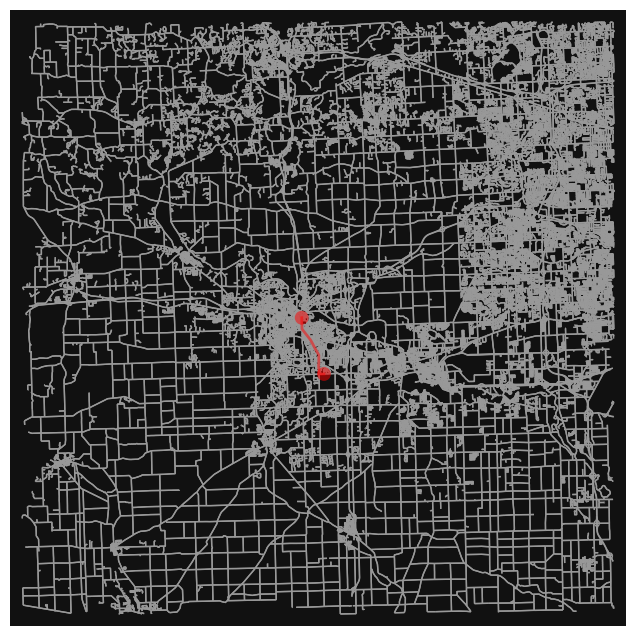


--- Plotting Weight Histograms ---


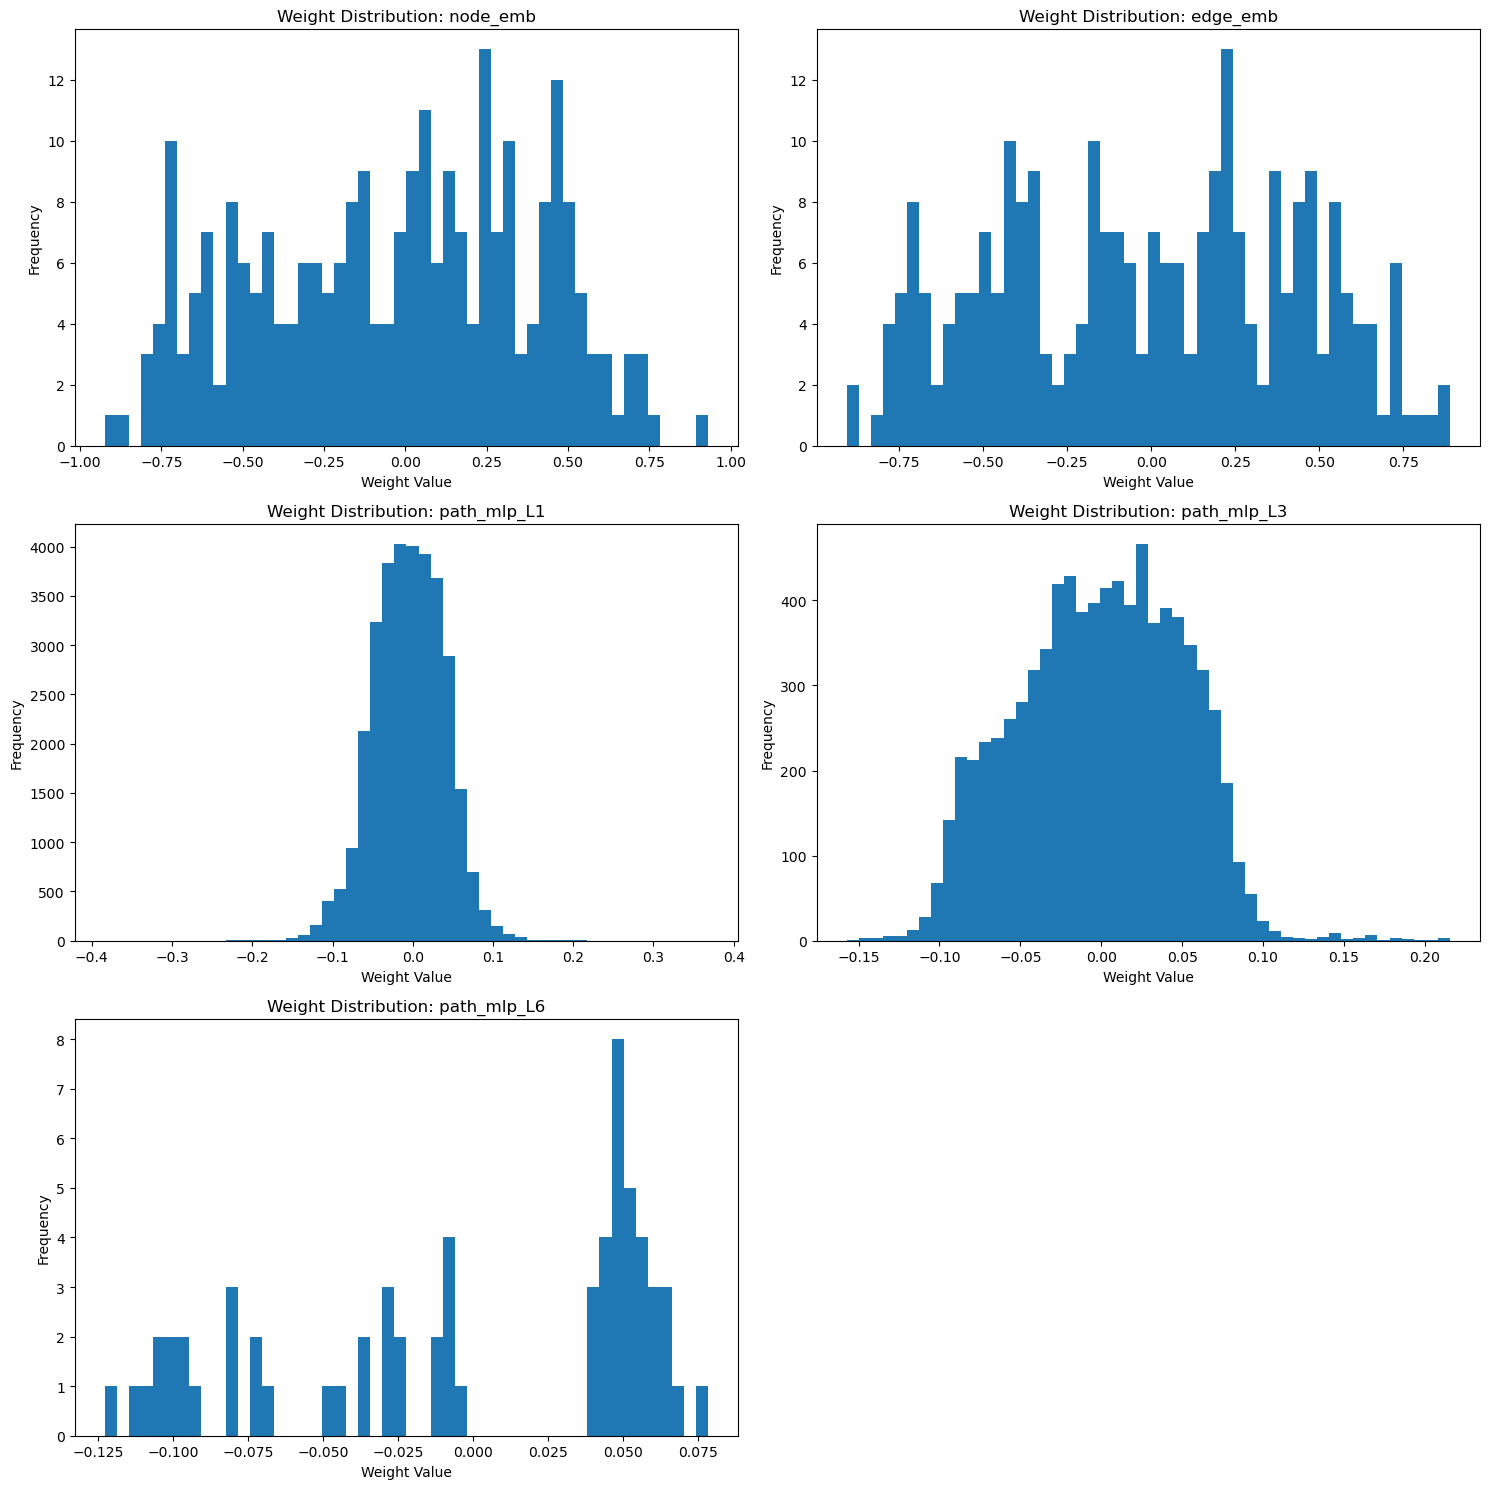

Note: Weight histograms primarily check for dying/exploding weights.
Direct interpretation for GNN performance is limited.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import joblib # If using StandardScaler

# --- Configuration & Loading ---
MODEL_SAVE_PATH = './best_energy_gnn_model.pth' # Make sure this is correct
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SCALING_METHOD = 'log1p' # Change to 'standard' if you used StandardScaler
# SCALER_PATH = 'energy_scaler.pkl' # Needed only if SCALING_METHOD == 'standard'

# --- Load Prerequisites (ensure these are available) ---
# graph, G, node_id_map, processed_trips_df, val_dataset, val_loader
# Make sure ComplexEnergyGNN (or EnergyGNN) class definition exists

# Load the best model state
try:
    node_feature_dim = graph.x.shape[1]
    edge_feature_dim = graph.edge_attr.shape[1]
    # Instantiate model structure (replace with your actual model class and params)
    model = ComplexEnergyGNN(
        node_dim=node_feature_dim,
        edge_dim=edge_feature_dim,
        hidden_dim=128, # Use params from training
        num_layers=4,   # Use params from training
        dropout=0.3     # Use params from training
    ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    model.eval() # Set to evaluation mode
    print(f"Model loaded successfully from {MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Model weights not found at {MODEL_SAVE_PATH}. Cannot perform analysis.")
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load scaler if needed
if SCALING_METHOD == 'standard':
    try:
        scaler = joblib.load(SCALER_PATH)
        print(f"Scaler loaded from {SCALER_PATH}")
    except FileNotFoundError:
        print(f"Error: Scaler not found at {SCALER_PATH}. Needed for standard scaling.")
        exit()
    except Exception as e:
        print(f"Error loading scaler: {e}")
        exit()


# Prepare graph data on device (if not already done)
try:
    graph_x = graph.x.clone().detach().to(DEVICE)
    graph_edge_index = graph.edge_index.clone().detach().to(DEVICE)
    graph_edge_attr = graph.edge_attr.clone().detach().to(DEVICE)
    pyg_graph_data_device = graph.to(DEVICE)
except Exception as e:
    print(f"Error preparing graph data on device: {e}")
    exit()

# Create inverse map: PyG index -> OSMnx node ID
idx_to_osmnx_node = {v: k for k, v in node_id_map.items()}

# --- Helper Function for Inverse Scaling ---
def inverse_scale_predictions(preds_tensor, method=SCALING_METHOD):
    """Applies inverse scaling to predictions."""
    preds_np = preds_tensor.cpu().numpy()
    if method == 'log1p':
        # Inverse of log(1+x) is exp(y) - 1
        return np.expm1(preds_np)
    elif method == 'standard':
        if 'scaler' not in globals():
             raise NameError("Scaler object not loaded. Cannot use standard inverse scaling.")
        # Scaler expects 2D array
        return scaler.inverse_transform(preds_np.reshape(-1, 1)).flatten()
    else: # Assume no scaling or unknown
        return preds_np

# --- Plotting Function (a): Route Visualization ---
def plot_route_prediction(model, pyg_graph_data, nx_graph, trips_df, dataset_idx, node_idx_to_osmid, title_prefix=""):
    """Plots a specific route and compares predicted vs actual energy."""
    model.eval()
    if dataset_idx >= len(trips_df):
        print(f"Error: dataset_idx {dataset_idx} is out of bounds for trips_df (size {len(trips_df)}).")
        return

    # Get trip data (source/dest are PyG indices)
    trip_info = trips_df.iloc[dataset_idx]
    src_idx = int(trip_info['source'])
    dst_idx = int(trip_info['destination'])
    actual_energy_proxy = float(trip_info['true_energy']) # Original scale

    # Get OSMnx Node IDs
    try:
        osmnx_src = node_idx_to_osmid[src_idx]
        osmnx_dst = node_idx_to_osmid[dst_idx]
    except KeyError as e:
        print(f"Error: Node index {e} not found in node_idx_to_osmid map.")
        return

    print(f"\nAnalyzing Trip Index: {dataset_idx}")
    print(f"  Source Index: {src_idx} (OSMnx ID: {osmnx_src})")
    print(f"  Dest Index: {dst_idx} (OSMnx ID: {osmnx_dst})")
    print(f"  Actual Energy Proxy (Original Scale): {actual_energy_proxy:.2f}")

    # Find shortest path on the NetworkX graph
    try:
        shortest_path_nodes = nx.shortest_path(nx_graph, source=osmnx_src, target=osmnx_dst, weight='length')
        print(f"  Shortest path found with {len(shortest_path_nodes)} nodes.")
    except nx.NetworkXNoPath:
        print(f"  Error: No path found between OSMnx nodes {osmnx_src} and {osmnx_dst} in the graph G.")
        return
    except nx.NodeNotFound as e:
        print(f"  Error: Node {e} not found in the NetworkX graph G during pathfinding.")
        return

    # Get model prediction (needs tensors for src/dst)
    src_tensor = torch.tensor([src_idx], dtype=torch.long).to(DEVICE)
    dst_tensor = torch.tensor([dst_idx], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        # Assuming model takes full graph data + src/dst nodes
        # pred_scaled = model(pyg_graph_data.x, pyg_graph_data.edge_index, pyg_graph_data.edge_attr, src_tensor, dst_tensor)
        pred_scaled = model(pyg_graph_data_device.x,
                    pyg_graph_data_device.edge_index,
                    pyg_graph_data_device.edge_attr,
                    src_nodes, dst_nodes)
    # Inverse scale the prediction
    pred_original_scale = inverse_scale_predictions(pred_scaled.squeeze())[0] # Get single value
    print(f"  Predicted Energy Proxy (Original Scale): {pred_original_scale:.2f}")

    # Plotting
    try:
        fig, ax = ox.plot_graph_route(nx_graph, shortest_path_nodes, route_color='r', route_linewidth=2, node_size=0)
        ax.set_title(f"{title_prefix}Trip {dataset_idx}: Pred={pred_original_scale:.1f} vs Actual={actual_energy_proxy:.1f}")
        plt.show()
    except Exception as e:
        print(f"  Error during plotting: {e}")


# --- Plotting Function (b): General Performance ---
def analyze_general_performance(model, loader, pyg_graph_data, original_trips_df):
    """Generates predictions for the validation set and plots performance."""
    model.eval()
    all_preds_original = []
    all_actuals_original = []
    print("\n--- Analyzing General Performance on Validation Set ---")

    # Need original scale actuals corresponding to the loader order
    # The loader shuffles if shuffle=True, so we need indices or use the dataset directly
    # Easiest is to iterate through the dataset (slower) or use loader with shuffle=False
    # Let's use the val_dataset directly to ensure alignment if loader shuffles
    val_indices = loader.dataset.trips.index # Get original indices from the validation split df
    original_scale_actuals_ordered = original_trips_df.loc[val_indices, 'true_energy'].values

    batch_num = 0
    with torch.no_grad():
        # Use the val_loader for batch processing
        for batch in tqdm(loader, desc="Validation Predictions"):
            src_nodes = batch['src'].to(DEVICE)
            dst_nodes = batch['dst'].to(DEVICE)
            # true_energy_scaled = batch['true_energy'].to(DEVICE) # Loader returns scaled energy

            pred_scaled = model(pyg_graph_data.x, pyg_graph_data.edge_index, pyg_graph_data.edge_attr, src_nodes, dst_nodes)

            # Inverse scale predictions
            preds_original_batch = inverse_scale_predictions(pred_scaled)
            all_preds_original.extend(preds_original_batch)

            # Collect corresponding actuals (already fetched in original_scale_actuals_ordered)
            start_idx = batch_num * loader.batch_size
            end_idx = start_idx + len(preds_original_batch) # Handle last incomplete batch
            # all_actuals_original.extend(original_scale_actuals_ordered[start_idx:end_idx]) # Collect actuals directly

            batch_num += 1

    # Now use the pre-ordered actuals
    all_actuals_original = original_scale_actuals_ordered[:len(all_preds_original)] # Ensure same length

    # Convert lists to numpy arrays
    all_preds_original = np.array(all_preds_original)
    all_actuals_original = np.array(all_actuals_original)

    # Remove NaNs or Infs resulting from inverse scaling if necessary
    valid_indices = np.isfinite(all_preds_original) & np.isfinite(all_actuals_original)
    all_preds_original = all_preds_original[valid_indices]
    all_actuals_original = all_actuals_original[valid_indices]

    if len(all_preds_original) == 0:
        print("Error: No valid predictions found after processing.")
        return

    # --- Calculate Metrics ---
    mae = mean_absolute_error(all_actuals_original, all_preds_original)
    rmse = np.sqrt(mean_squared_error(all_actuals_original, all_preds_original))
    r2 = r2_score(all_actuals_original, all_preds_original)

    print("\nValidation Set Performance Metrics (Original Scale):")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R^2:  {r2:.4f}")
    print(f"  (Remember this is based on the energy *proxy*)")

    # --- Scatter Plot ---
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=all_actuals_original, y=all_preds_original, alpha=0.5, s=10)
    # Add y=x line
    min_val = min(all_actuals_original.min(), all_preds_original.min()) * 0.9
    max_val = max(all_actuals_original.max(), all_preds_original.max()) * 1.1
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y=x)')
    plt.xlabel("Actual Energy Proxy (Original Scale)")
    plt.ylabel("Predicted Energy Proxy (Original Scale)")
    plt.title(f"Actual vs. Predicted Energy Proxy (Validation Set)\nMAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")
    plt.legend()
    plt.grid(True)
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.show()

# --- Plotting Function (c): Weight Visualization (Basic) ---
def plot_weight_histograms(model, bins=50):
    """Plots histograms of weights for key linear layers."""
    print("\n--- Plotting Weight Histograms ---")
    plot_count = 0
    layers_to_plot = { # Example layers - adjust based on your model
        'node_emb': model.node_emb,
        'edge_emb': model.edge_emb,
        'path_mlp_L1': model.path_mlp[0], # First linear layer of path_mlp
        'path_mlp_L3': model.path_mlp[3], # Second linear layer of path_mlp
        'path_mlp_L6': model.path_mlp[6], # Final linear layer of path_mlp
    }

    # Add GINEConv MLP weights if desired (more complex to access)
    # Example for first GINE layer's internal MLP
    # if hasattr(model, 'convs') and len(model.convs) > 0 and hasattr(model.convs[0], 'nn'):
    #     gine_mlp = model.convs[0].nn
    #     if isinstance(gine_mlp, nn.Sequential) and len(gine_mlp) > 0 and isinstance(gine_mlp[0], nn.Linear):
    #          layers_to_plot['gine0_mlp_L1'] = gine_mlp[0]

    plt.figure(figsize=(15, 5 * ((len(layers_to_plot) + 1) // 2)))

    for name, layer in layers_to_plot.items():
         if isinstance(layer, nn.Linear):
             plot_count += 1
             plt.subplot((len(layers_to_plot) + 1) // 2, 2, plot_count)
             weights = layer.weight.data.cpu().numpy().flatten()
             plt.hist(weights, bins=bins)
             plt.title(f"Weight Distribution: {name}")
             plt.xlabel("Weight Value")
             plt.ylabel("Frequency")

    if plot_count == 0:
        print("No suitable Linear layers found to plot in the specified paths.")
        return

    plt.tight_layout()
    plt.show()
    print("Note: Weight histograms primarily check for dying/exploding weights.")
    print("Direct interpretation for GNN performance is limited.")


# --- Run the Analysis ---
if __name__ == "__main__": # Prevents running automatically if imported
    # Ensure val_loader and val_dataset exist
    if 'val_loader' not in globals() or 'val_dataset' not in globals():
        print("Error: val_loader or val_dataset not defined. Run the training loop script first.")
    else:
        # --- Analyze General Performance ---
        analyze_general_performance(model, val_loader, graph, processed_trips_df)

        # --- Analyze a Specific Route ---
        # Get the DataFrame used by the validation dataset to ensure index alignment
        validation_trips_df = val_loader.dataset.trips
        if not validation_trips_df.empty:
            # Choose a random index from the validation set
            random_idx_val = random.randint(0, len(validation_trips_df) - 1)
            # Get the corresponding index in the *original* processed_trips_df
            original_df_idx = validation_trips_df.index[random_idx_val]
            plot_route_prediction(model, graph, G, processed_trips_df, original_df_idx, idx_to_osmnx_node, title_prefix="Validation ")

            # Optionally plot another one
            # random_idx_val_2 = random.randint(0, len(validation_trips_df) - 1)
            # original_df_idx_2 = validation_trips_df.index[random_idx_val_2]
            # plot_route_prediction(model, graph, G, processed_trips_df, original_df_idx_2, idx_to_osmnx_node, title_prefix="Validation ")
        else:
            print("Validation dataset is empty, cannot plot specific route.")

        # --- Analyze Weights ---
        plot_weight_histograms(model)